# Random forest model using multiple day observations

## Import libraries

In [1]:
# Accelerate scikit learn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier

## Load data

In [3]:
data = pd.read_csv('../output/sim_1_zero_onset.csv')

## Reformat data to group by patient ID

In [4]:
data_arrays = []

for name, group in data.groupby('patient_id'):
    infant_data = dict()
    X_fields = ['gi', 'pulmonary', 'brain']
    infant_data['patient_id'] = name
    for field in X_fields:
        infant_data[field] = group[field].values
        infant_data['died'] = group['died'].values
        infant_data['condition'] = group['condition'].values[0]
        infant_data['condition_active'] = group['condition_active'].values
    data_arrays.append(infant_data)

data_arrays = pd.DataFrame(data_arrays)

In [5]:
results = []
days = np.arange(1,50,1)

for day in days:
    restricted_data = pd.DataFrame()
    
    # Add patient_id and conditions
    restricted_data['patient_id'] = data_arrays['patient_id']
    restricted_data['condition'] = data_arrays['condition']
    
    # Truncate X by the max day
    X_fields = ['gi', 'pulmonary', 'brain']
    f = lambda x: x[0:day]
    for field in X_fields:
        restricted_data[field] = data_arrays[field].map(f)
        
    # Truncate data on died and find max
    died = data_arrays['died'].map(f)
    f = lambda x: np.max(x[0:day])
    restricted_data['died'] = died.map(f)
    
    # Remove infants who have died
    mask = restricted_data['died'] == 0
    restricted_data = restricted_data[mask]
        
    # Combine all X data fileds into a single array
    X_data = restricted_data[X_fields].values
    combined = []
    for row in X_data:
        combined.append(np.concatenate(row))
    restricted_data['combined_x'] = combined
    
     # Use boot strap k_folds
    for k in range(30):
            
        # Split into train and test
        ids = list(set(restricted_data['patient_id']))
        random.shuffle(ids)
        count_ids = len(ids)
        train_count = int(count_ids) * 0.8
        train_ids = ids[0:(int(train_count))]
        test_ids = ids[(int(train_count)):]
        
        f = lambda x: x in train_ids
        mask = restricted_data['patient_id'].map(f)
        train = restricted_data[mask]
        f = lambda x: x in test_ids
        mask = restricted_data['patient_id'].map(f)
        test = restricted_data[mask]
        
        # Get X and y
        X_train = train['combined_x'].values
        X_test = test['combined_x'].values
        y_train = train['condition']
        y_test = test['condition']
            
        # Convert from object to array
        X_train = np.array(list(X_train[:]), dtype=float)
        X_test = np.array(list(X_test[:]), dtype=float)

        # Fit model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        # Get accuracy and probabiltiies
        y_pred_test = model.predict(X_test)
        y_pred_prob = []
        prob = model.predict_proba(X_test)
        for indx, p in enumerate(prob):
            y_pred_prob.append(p[y_pred_test[indx]])
        accuracy = np.mean(y_pred_test == y_test)
        mean_probability = np.mean(y_pred_prob)
        day_results = dict()
        day_results['day'] = day
        day_results['k_fold'] = k
        day_results['accuracy'] = accuracy
        day_results['mean_probability'] = mean_probability
        results.append(day_results)
        
        del model
    
results = pd.DataFrame(results)    

# Calculate mean results
cols_without_kfold = list(results); cols_without_kfold.remove('k_fold')
cols_to_average = ['day']
av_results = results[cols_without_kfold].groupby(cols_to_average).mean()
av_results = av_results.reset_index()

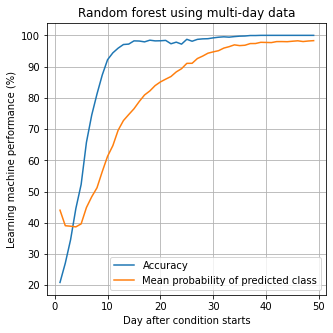

In [6]:
# Set up figure
fig = plt.figure(figsize=(5,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(av_results['day'], av_results['accuracy']*100, label='Accuracy')
ax.plot(av_results['day'], av_results['mean_probability']*100, 
        label='Mean probability of predicted class')
ax.set_xlabel('Day after condition starts')
ax.set_ylabel('Learning machine performance (%)')
ax.set_title('Random forest using multi-day data')

plt.grid()
plt.legend()
plt.savefig('./rf_multi_day.png', dpi=300)
plt.show()